# Models: Generalized Matrix Factorization (GMF)

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH             = '../..'
LIB_PATH              = f'{BASE_PATH}/lib'

In [18]:
import sys
sys.path.append(LIB_PATH)

import pandas as pd
from bunch import Bunch

import torch
import pytorch_common
import pytorch_common.util as pu

import model as ml
import service as srv
import model.training as mt

import util as ut

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [9]:
pytorch_common.__version__

'0.3.2'

In [12]:
torch.__version__

'2.0.1+cu118'

In [13]:
pu.set_device_name('gpu')
pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [16]:
ut.set_seed(42)

## Classes

## Definicion del modelo

In [19]:
train_set = pd.read_json("/var/tmp/rec-sys-client/compute_knn_item_based_rating_matrix_train_interactions.json")
test_set  = pd.read_json("/var/tmp/rec-sys-client/compute_knn_item_based_rating_matrix_future_interactions.json")

train_ds = mt.DatasetFactory().create_from(train_set)
test_ds  = mt.DatasetFactory().create_from(test_set)

In [21]:
params = Bunch({    
    'model': Bunch({
        'n_users'       : len(train_ds.features_uniques[0]),
        'n_items'       : len(train_ds.features_uniques[1]),
        'device'        : pu.get_device(),
        'embedding_size': 50,
        'weights_path'  : f'{BASE_PATH}/weights'
    }),
    'train': Bunch({
        'lr'         : 0.001,
        'lr_factor'  : 0.05,
        'lr_patience': 3,
        'epochs'     : 12,
        'n_workers'  : 24,
        'batch_size' : 64
    }),
    'metrics': Bunch({
        'experiment' : 'gmf',
        'path'       : f'{BASE_PATH}/metrics/gmf',
        'n_samples'  : 100,
        'batch_size' : 5000
    })
})

model = ml.GMF(
    n_users        = params.model.n_users,
    n_items        = params.model.n_items,
    embedding_size = params.model.embedding_size
)

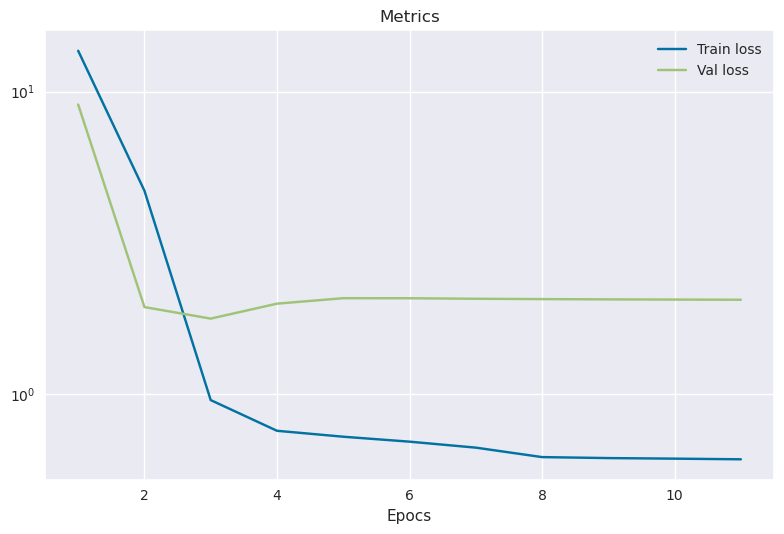

2023-08-22 22:40:10,838 - INFO - {'time': '0:00:11.34', 'epoch': 12, 'train_loss': 0.6040122793380157, 'val_loss': 2.048682451248169, 'lr': 2.5e-06}


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Ordered by mAP@5(4,5):


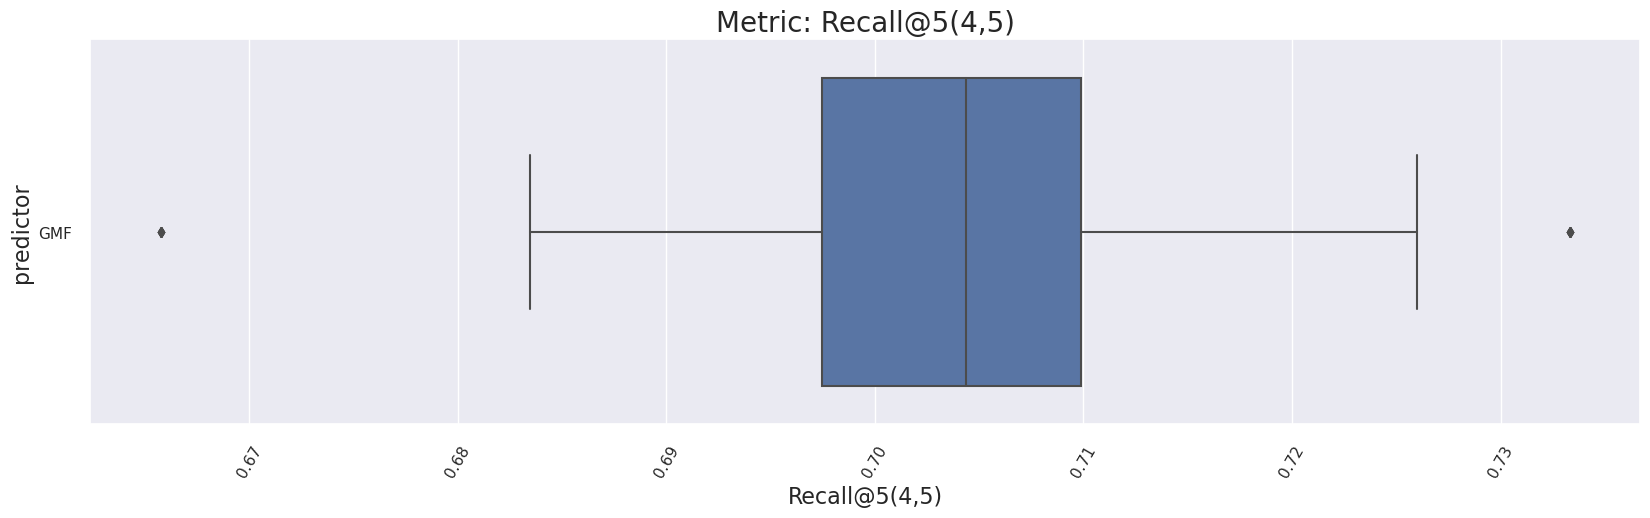

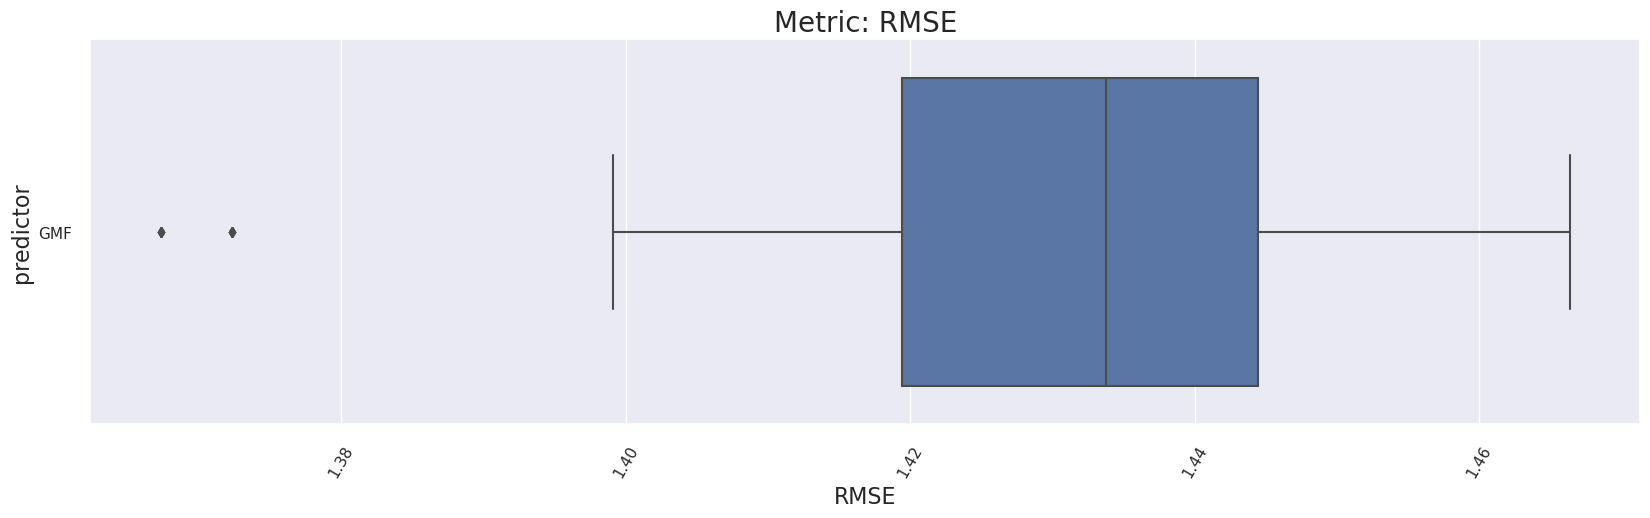

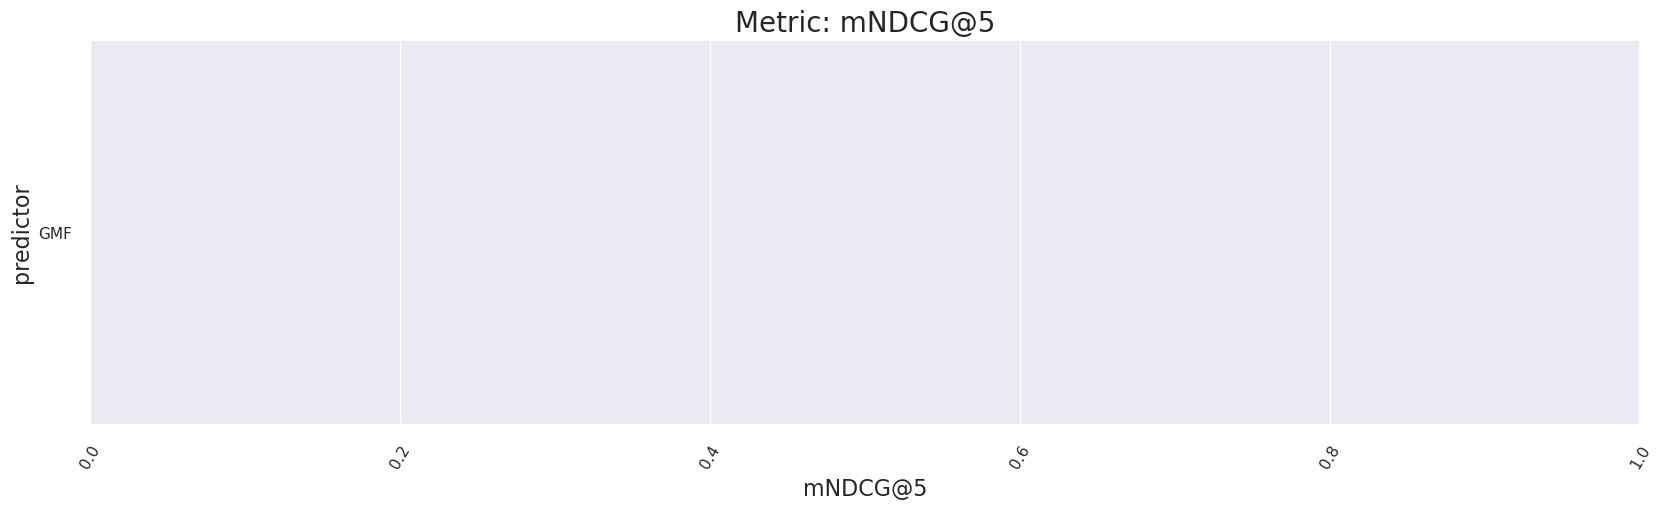

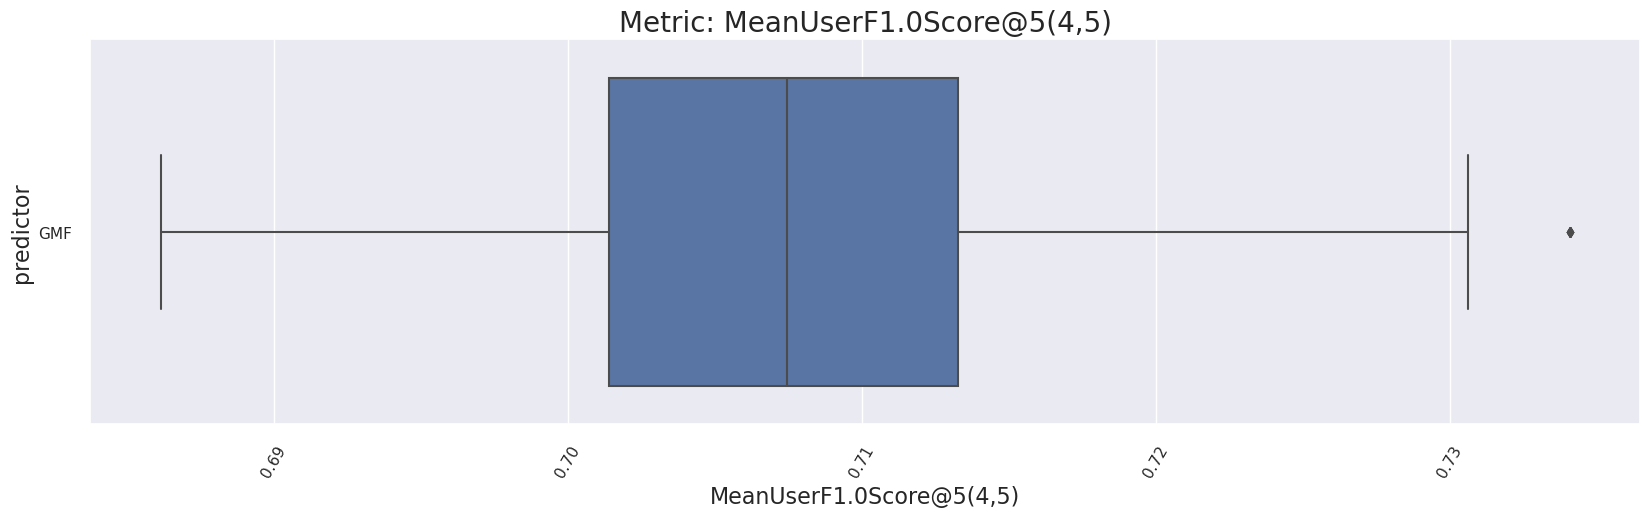

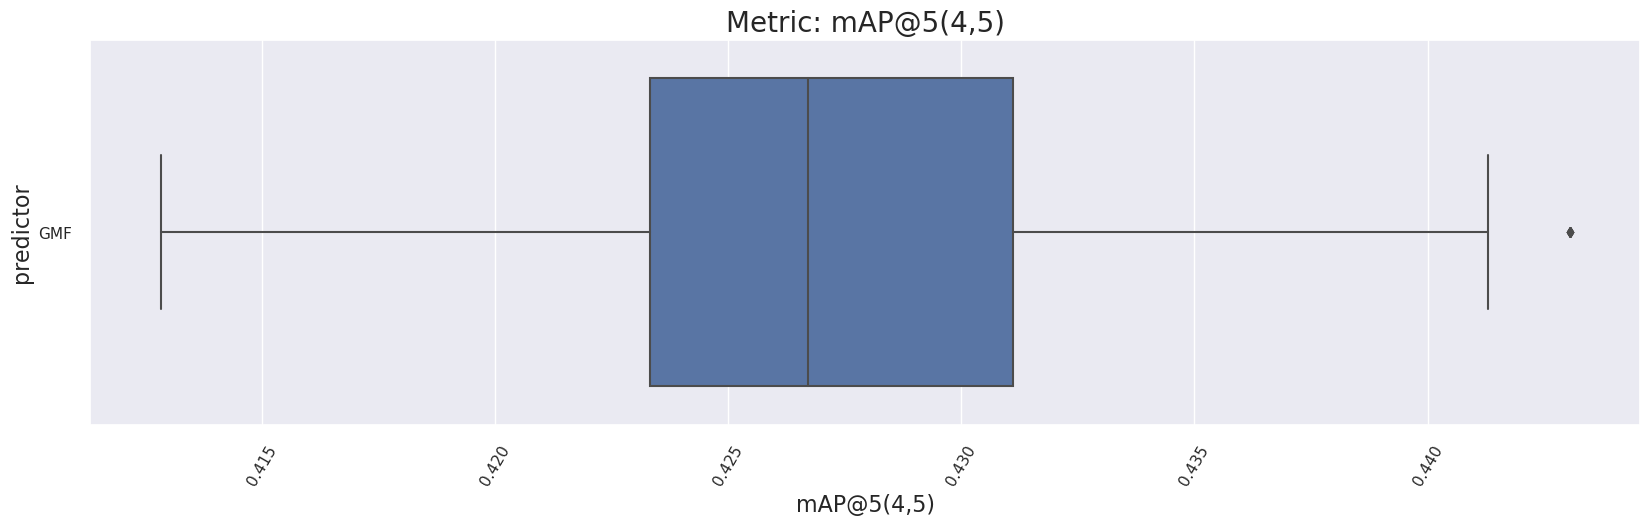

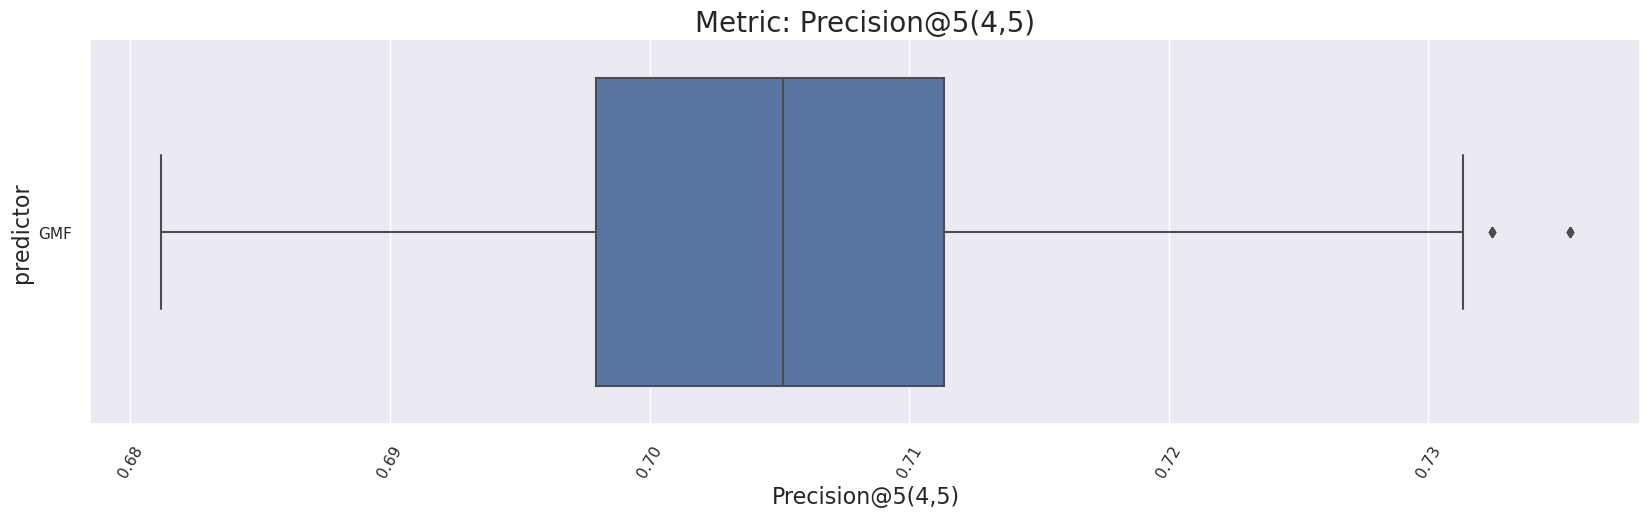

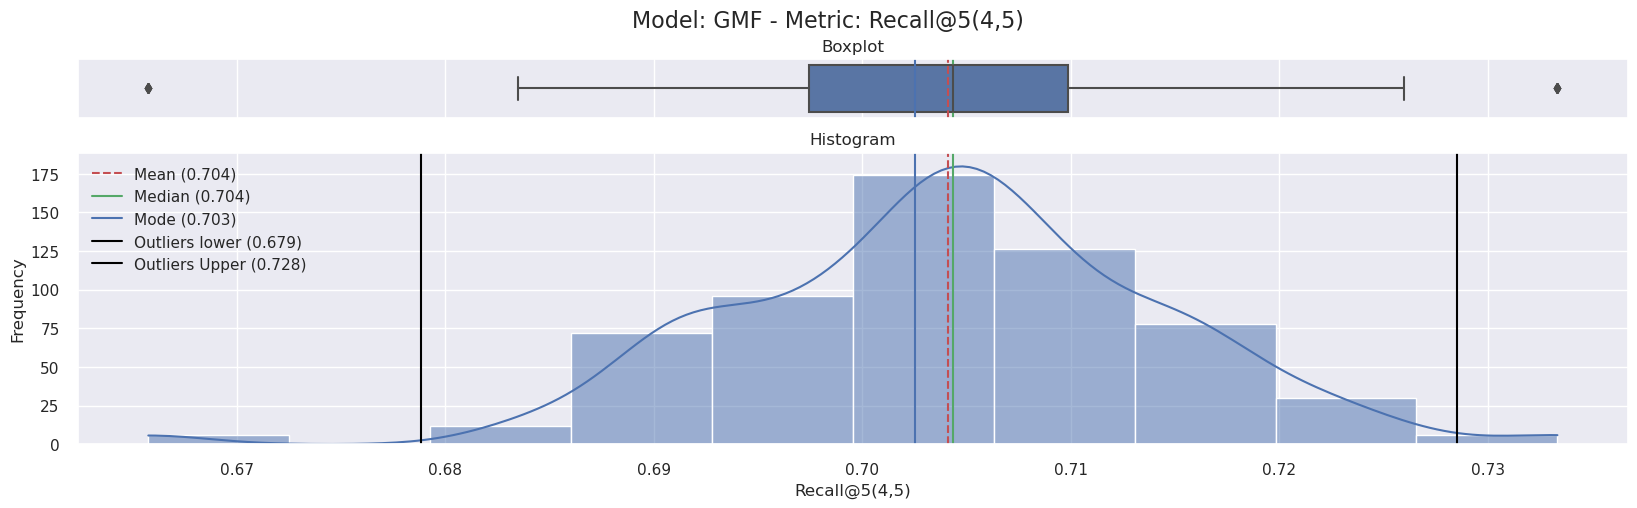

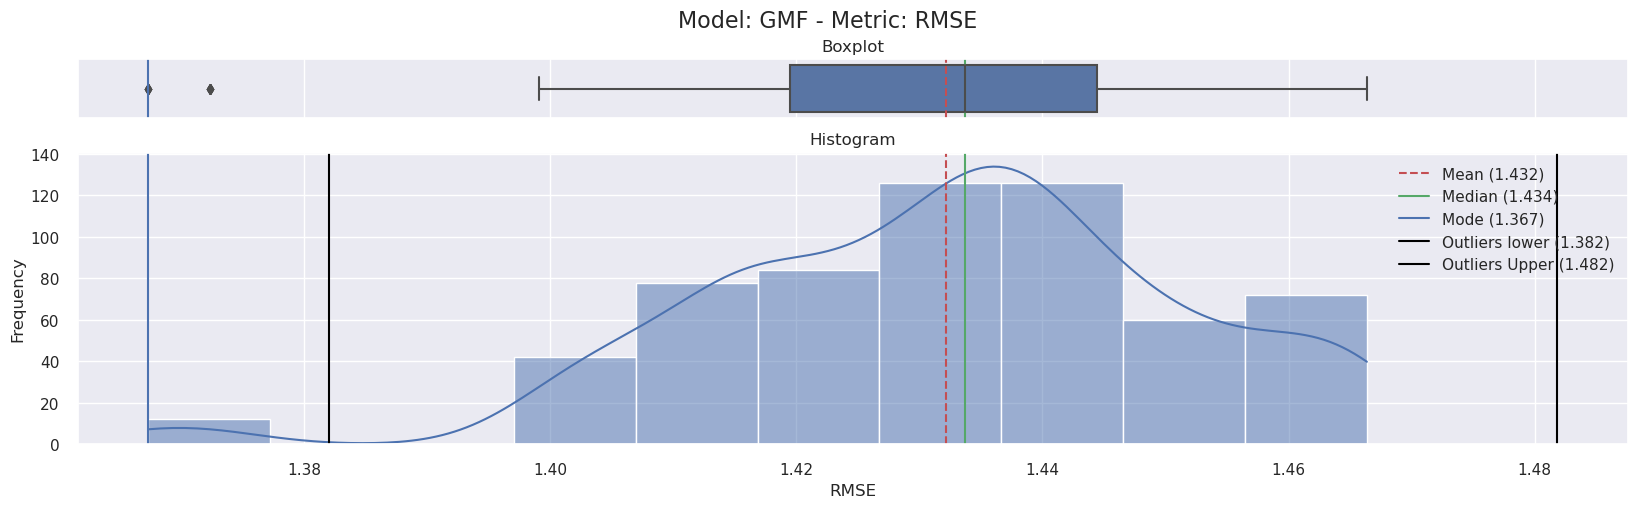

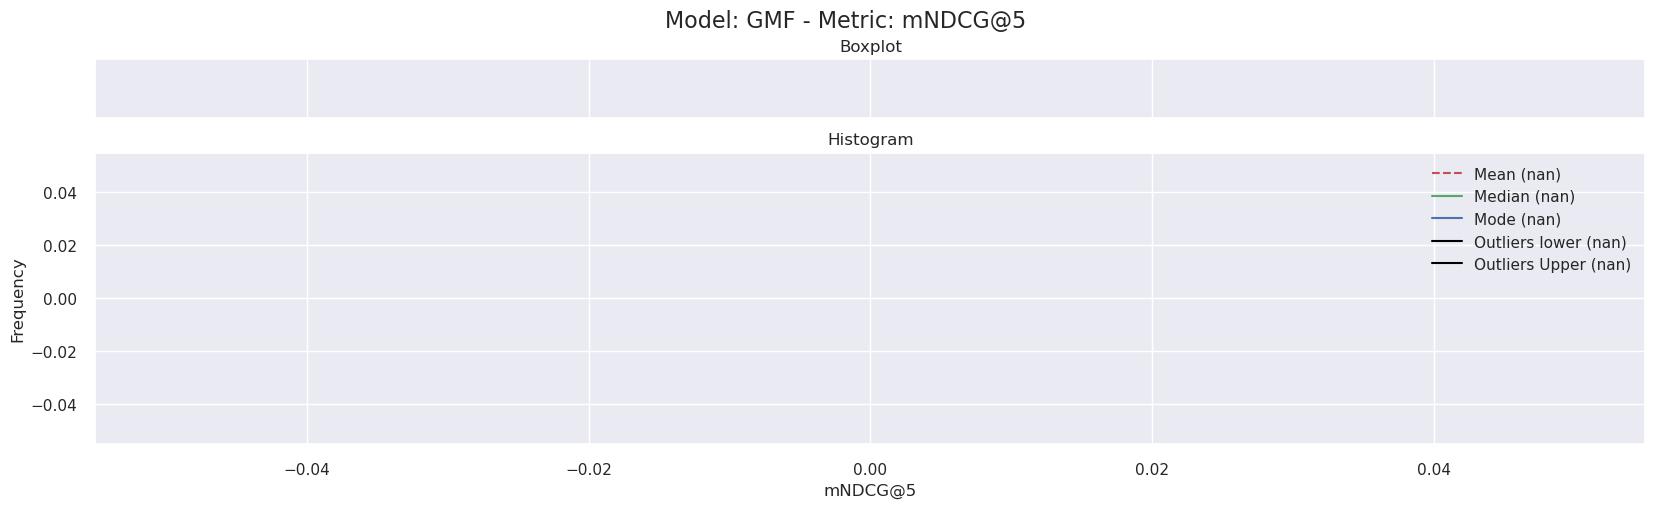

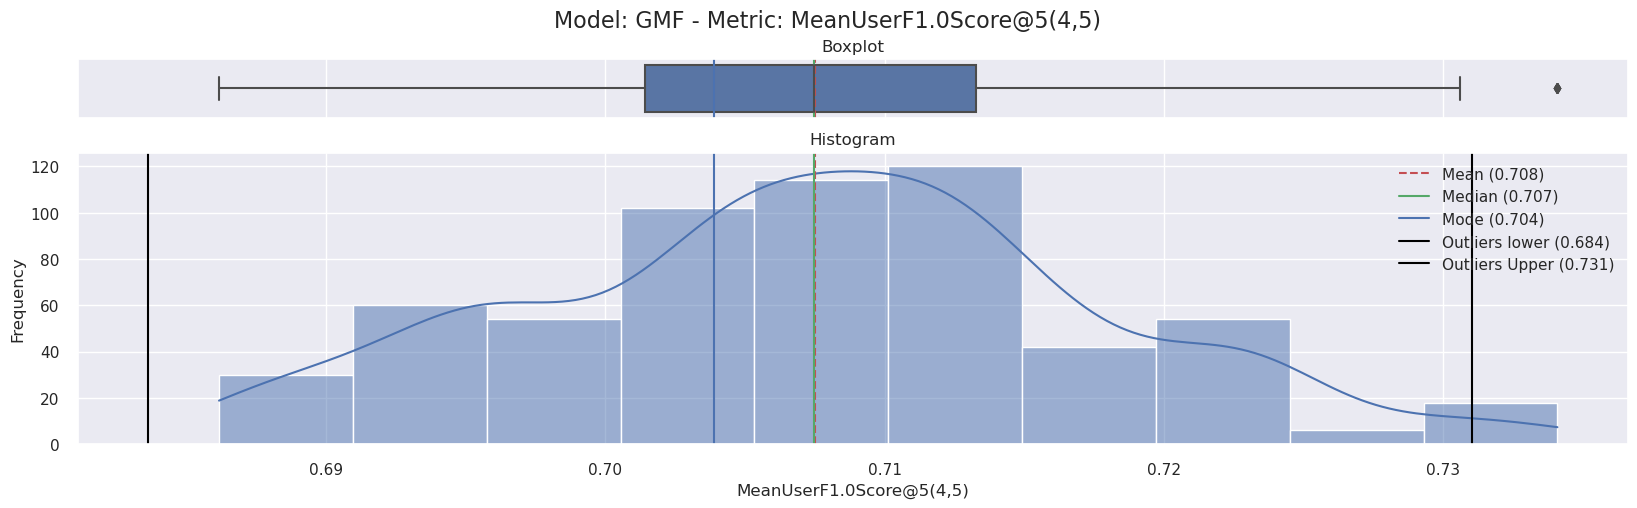

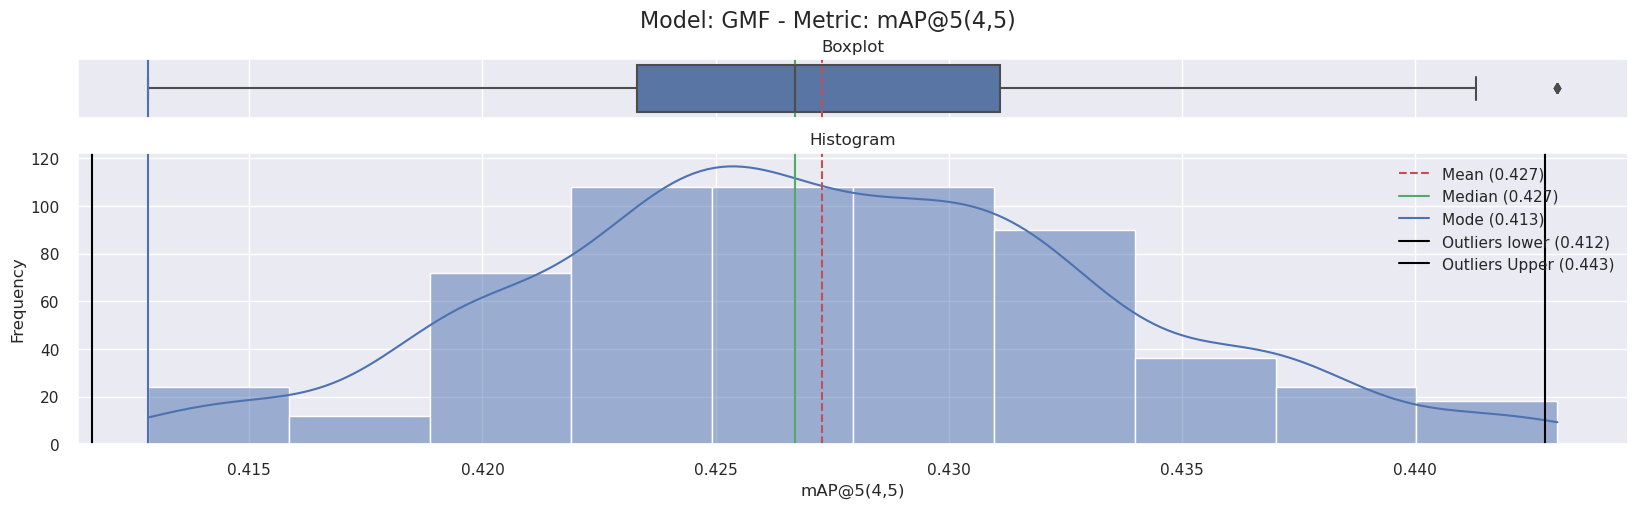

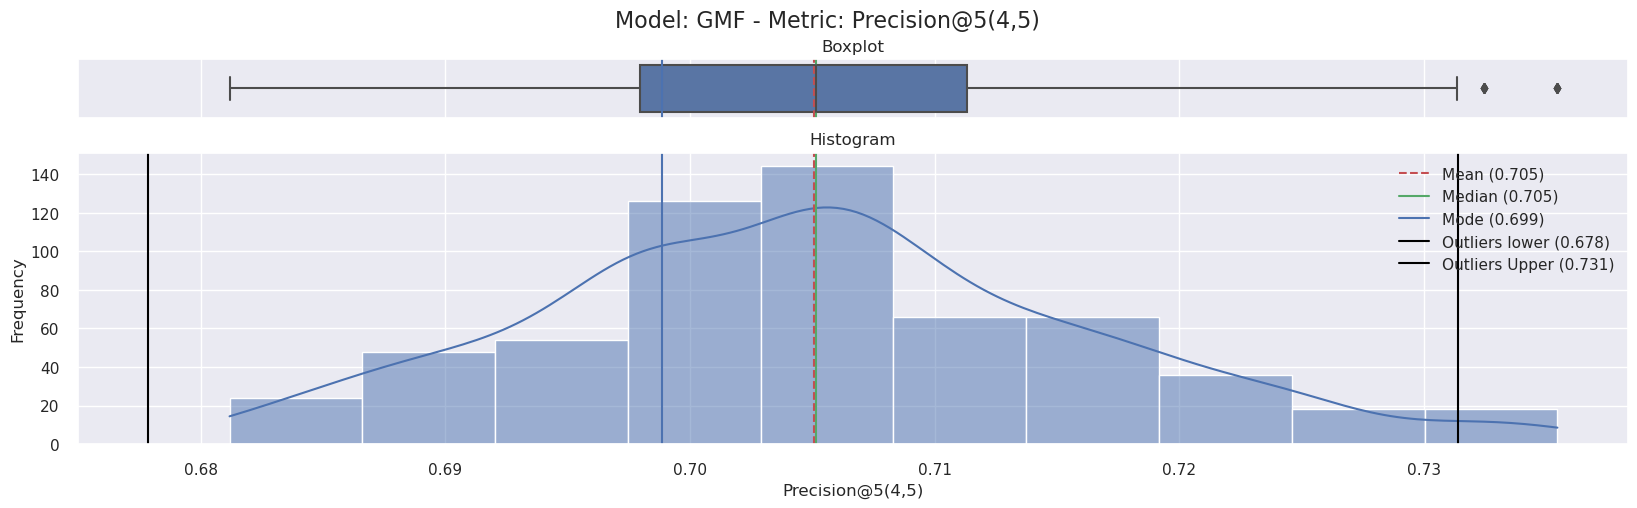

,sample,RMSE,mNDCG@5,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)"
predictor,,,,,,,
GMF,49.5,1.432136,NaN,0.427292,0.707515,0.705074,0.704112


In [25]:
service = srv.ModulePredictionService(model, params)

service.train(train_ds, test_ds)

In [28]:
service.predict(test_set)

,user_seq,item_seq,rating,rating_prediction
0,0,74,3.740453,3.481386
1,0,75,3.541793,3.290766
2,0,76,3.094617,3.436517
3,0,77,3.763175,3.018904
4,0,78,3.403111,3.877694
...,...,...,...,...
148766,462,391,3.990433,2.537519
148767,462,392,3.234859,2.199228
148768,462,393,4.000000,2.494300
148769,462,394,3.665554,2.420339
